# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

### Note:
For transfer learning, it is advised to study this tutorial by PyTorch:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
# Imports here
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from collections import OrderedDict
from workspace_utils import active_session
import seaborn as sns



plt.ion()   # interactive mode

In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("Numpy Version: ", np.__version__)

PyTorch Version:  0.4.0
Torchvision Version:  0.2.1
Numpy Version:  1.12.1


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

#store the directory in a dict
directory={'train': train_dir,
          'valid': valid_dir}

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
trans_mean=[0.485, 0.456, 0.406]
trans_std= [0.229, 0.224, 0.225]

#how many samples per batch to load
batch_size=32

train_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, hue=.05, saturation=.05),
    transforms.RandomRotation((-90,90)),
    transforms.RandomVerticalFlip(),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAffine(degrees=(-45,45),shear=(-45,45)),
    transforms.Pad(5),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=trans_mean, std=trans_std)
])

#no augmentation on valid data

valid_transforms=transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=trans_mean, std=trans_std)])

#no agumentation on test data

test_transforms=  transforms.Compose([

    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=trans_mean, std=trans_std)])

data_transforms={'train': train_transforms,
                'valid': valid_transforms}

Understand how the data folder is defined:<br>
flowers
- train
    - 101
        - image_07942.jpg
        - image_07943.jpg
    - 102
        - image_08000.jpg
        - image_08007.jpg
        
Ideal loader for configuraton is [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder)

In [5]:
# TODO: Load the datasets with ImageFolder
image_datasets={key: datasets.ImageFolder(directory[key],
                                          transform=data_transforms[key]) for key in directory}


test_dataset= datasets.ImageFolder(root=test_dir, transform=test_transforms)

In [6]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
batch_size=32

dataloaders= {key: torch.utils.data.DataLoader(image_datasets[key], batch_size=batch_size,
                                              shuffle=True) for key in directory}

test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [7]:
dataset_sizes = {key: len(image_datasets[key]) for key in directory}
class_names = image_datasets['train'].classes

### Training Device

In [8]:
#make code device agnostic
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    device=torch.device("cuda")
    print('CUDA is available... Training on GPU')
else:
    device=torch.device('cpu')
    print('CUDA is not available... Training on CPU')

CUDA is available... Training on GPU


### Visualize Transformed Images

Typical images are in RGB. We will probably use a VGG model which [BGR images] input(https://github.com/jcjohnson/neural-style/issues/207). For the function below, this means transposing the color chanels to match expected input

In [9]:
def transviz(inp, title=None):
    """
    Expects a tensor input and shows it after transforms
    """
    inp=inp.numpy().transpose((1, 2, 0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    inp= std*inp + mean
    #, values outside the interval are clipped to the interval edges
    inp=np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #pause to update plots

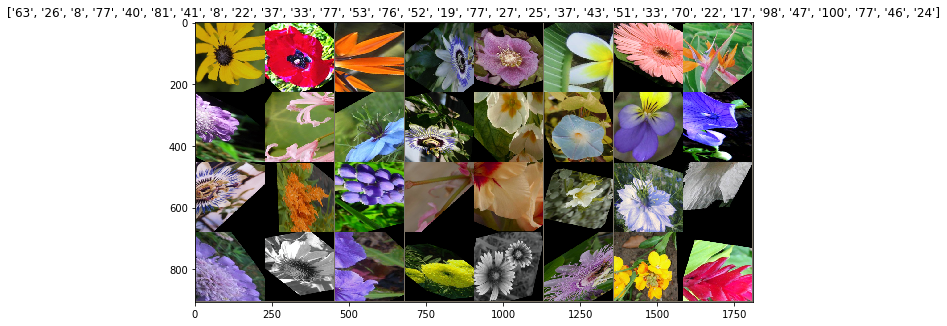

In [10]:
#get a batch
inputs, classes = next(iter(dataloaders['train']))

#make a grid from batch
out= torchvision.utils.make_grid(inputs, nrow=8)

#plot
transviz(out, title=[class_names[x] for x in classes])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [11]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [12]:
#load vgg16
model = models.vgg19(pretrained=True)
#see what's up
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:10<00:00, 53573998.32it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [13]:
#freeze parameters to stop backprop
for param in model.parameters():
    param.requires_grad=False

In [14]:
#change the classifer to adapt to current needs
classifier =nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu1', nn.ReLU()),
    ('drop1', nn.Dropout(p=0.5)),
    ('fc2', nn.Linear(4096, 1024)),
    ('relu2', nn.ReLU()),
    ('drop2', nn.Dropout(p=0.5)),
    ('fc3', nn.Linear(1024, len(cat_to_name))),
    ('output', nn.LogSoftmax(dim=1))
]))

#implement the change
model.classifier=classifier
#check our work
model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.5)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.5)
  (fc3): Linear(in_features=1024, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [15]:
# The negative log likelihood loss. It is useful to train a classification problem with C classes.
criterion= nn.NLLLoss()

Pytorch offers many optimizers through [torch.optim](https://pytorch.org/docs/stable/optim.html). [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/index.html#amsgrad) provides a great explanation of the optimization algorithms.

In [16]:
#pick optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [17]:
def train_model(model, criterion, optimizer, num_epochs=20, device='cpu'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    model.to(device)
    
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                optimizer.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #NB: calling a global variable inside a function
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            #Save the loss for inference
            if phase=='train':
                train_losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses

In [18]:
with active_session():
       model_ft ,train_losses, test_losses = train_model(model, criterion,
                                                         optimizer, num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 4.0428 Acc: 0.1155
valid Loss: 2.9945 Acc: 0.2579

Epoch 1/9
----------
train Loss: 3.2842 Acc: 0.2231
valid Loss: 2.4725 Acc: 0.3778

Epoch 2/9
----------
train Loss: 3.0833 Acc: 0.2657
valid Loss: 2.2368 Acc: 0.4181

Epoch 3/9
----------
train Loss: 2.9383 Acc: 0.2990
valid Loss: 2.2458 Acc: 0.4340

Epoch 4/9
----------
train Loss: 2.8937 Acc: 0.3098
valid Loss: 2.0346 Acc: 0.4389

Epoch 5/9
----------
train Loss: 2.8033 Acc: 0.3226
valid Loss: 1.9751 Acc: 0.4682

Epoch 6/9
----------
train Loss: 2.8333 Acc: 0.3291
valid Loss: 2.0013 Acc: 0.4963

Epoch 7/9
----------
train Loss: 2.7250 Acc: 0.3452
valid Loss: 1.8418 Acc: 0.5232

Epoch 8/9
----------
train Loss: 2.7063 Acc: 0.3429
valid Loss: 1.9643 Acc: 0.4768

Epoch 9/9
----------
train Loss: 2.6870 Acc: 0.3547
valid Loss: 1.8416 Acc: 0.5293

Training complete in 77m 42s
Best val Acc: 0.529340


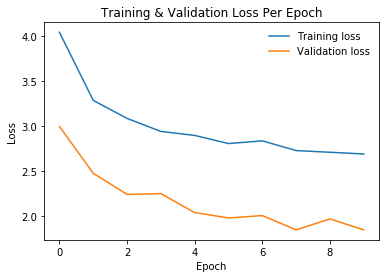

In [39]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training & Validation Loss Per Epoch")
plt.savefig('vgg19_2019-03-29.png')
plt.legend(frameon=False)
plt.show()

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In the part below, it is useful to check out this [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). Our aim is to display accuracy on the test set and a breakdown across different categories.

In [20]:
correct = 0 # num of correct preds
total =0 #total size of dataset

model.eval()
with torch.no_grad(): #turn off training
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs= model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 49 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [21]:
# TODO: Save the checkpoint 
model_ft.class_to_idx = image_datasets['train'].class_to_idx

In [22]:
#make sure to move model to cpu before saving
model_ft.to('cpu');

In [23]:
model_dict={'arch': 'vgg19',
            'state_dict': model_ft.state_dict(), 
            'class_to_idx': model_ft.class_to_idx,
            'optimizer_state_dict': optimizer.state_dict(),
            'weights': model_ft.features}

In [24]:
torch.save(model_dict,'savedmodels/vgg19_2019_03_29.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [25]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

In [27]:
def load_model(checkpoint_path):
    
    model=models.vgg19(pretrained=True)
    
    classifier =nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, 4096)),
        ('relu1', nn.ReLU()),
        ('drop1', nn.Dropout(p=0.5)),
        ('fc2', nn.Linear(4096, 1024)),
        ('relu2', nn.ReLU()),
        ('drop2', nn.Dropout(p=0.5)),
        ('fc3', nn.Linear(1024, 102)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
    #freeze parameters to stop backprop
    for param in model.parameters():
        param.requires_grad=False

    #implement the change
    model.classifier=classifier
    
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx= checkpoint['class_to_idx']
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer

In [28]:
model_vgg19, optimizer = load_model('savedmodels/vgg19_2019_03_29.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

Note the [Pillow library Coordinate System](https://pillow.readthedocs.io/en/3.3.x/handbook/concepts.html#coordinate-system):
The Python Imaging Library uses a Cartesian pixel coordinate system, with (0,0) in the upper left corner. Note that the coordinates refer to the implied pixel corners; the centre of a pixel addressed as (0, 0) actually lies at (0.5, 0.5).

In [29]:
#function to crop image
def crop_image(pil_image, new_width=224, new_height=224):

    width, height = pil_image.size 
 
    left = (width - new_width)/2
    bottom = (height - new_height)/2
    top = (height + new_height)/2
    right = (width + new_width)/2
    
    box=(left, bottom, right, top)
    

    cropped_image=pil_image.crop(box)
    
    return cropped_image

In [30]:
def process_image(image, mean= np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    #open image in read mode
    image=Image.open(image, mode='r')
    
    #scale image, use smaller dimension as resize argument
    width, height = image.size
    if width>height:
        image.thumbnail((1e6, 256))
    else:
        image.thumbnail((256, 1e6))
        
    #crop image
    
    image=crop_image(image)
    
    #normalize
    image=np.array(image)/255
    image=(image-std)/mean
    
    #reorder dimensions 
    image=image.transpose((2,0,1))
    
    return image
    
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [31]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

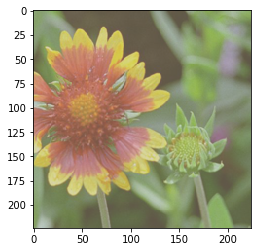

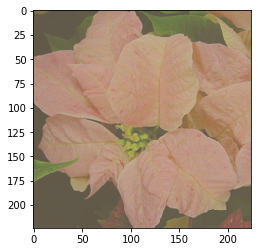

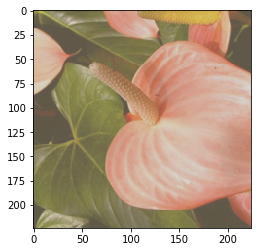

In [32]:
#pick random images
image_1 = 'flowers/train/100/image_07930.jpg'
image_2= 'flowers/train/44/image_01547.jpg'
image_3= 'flowers/train/80/image_02063.jpg'

imshow_images=[image_1, image_2, image_3]

for image in imshow_images:
    image= process_image(image)
    imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [33]:
def predict(image_path, model, topk=5, device='cpu'):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    #process image for PyTorch mode
    image=process_image(image_path)
    
    #convert torch to tensor
    tensor_image= torch.from_numpy(image).type(torch.FloatTensor)
    
    #return a tensor with all the dimensions of input size of 1 removed 
    squeeze_image=tensor_image.unsqueeze(0)
    
    #move image to device
    squeeze_image=squeeze_image.to(device)
    
    #move model to device
    model.to(device)
    
    #extract probability
    with torch.no_grad():
        proba=torch.exp(model.forward(squeeze_image))
        #return k largest elements of input tensor with dimensions
        top_probas, top_labels= proba.topk(topk)
        
    #move the probas and labels to cpu
    top_probas= top_probas.to('cpu')
    top_labels= top_labels.to('cpu')
    
    #convert probas and labels to numpy array
    top_probas= top_probas.detach().numpy().tolist()[0]
    top_labels= top_labels.detach().numpy().tolist()[0]
    
    #convert numeric label to categirocal label
    idx_to_class={val: key for key, val in model.class_to_idx.items()}
    
    top_labels=[idx_to_class[int(lab)] for lab in top_labels]
    top_flowers= [cat_to_name[idx_to_class[int(label)]] for label in top_labels]
    
    return top_probas, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [34]:
# TODO: Display an image along with the top 5 classes

In [35]:
def plot_flower(path, model):
    
    #plot area
    plt.figure(figsize=(6, 6))
    ax=plt.subplot(2, 1, 1)
    
    #flower files are set up as flower_data/train/xx/blablabla.jpg
    #we want to extract the xx label for the flower number
    flower_number=path.split('/')[2]
    image_title = cat_to_name[flower_number]
    
    #process the image
    image=process_image(path)
    
    #show the image
    imshow(image, ax, title = image_title)
    
    #predict top 5 flowers
    top_probas, top_labels, top_flowers=predict(path, model)
    
    #plot top 5 predictions
    plt.subplot(2, 1, 2)
    sns.barplot(x=top_probas, y=top_flowers, color=sns.color_palette()[0])
    
    #show everything
    plt.show()

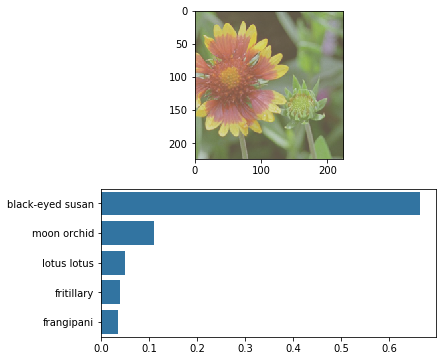

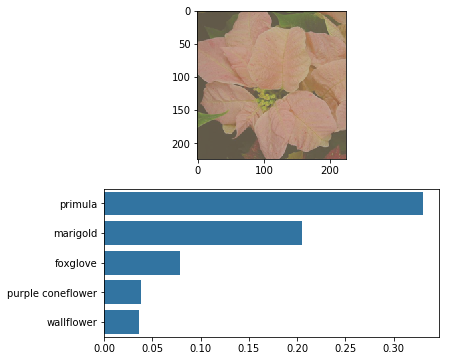

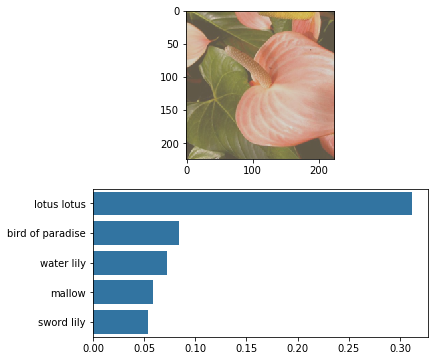

In [36]:
for image in imshow_images:
    plot_flower(image, model_vgg19)